# Problem Description

- The competition is called : **Corporacion Favorita Grocery Sales Forecasting**.
- The task is to predict sales in the stores of an Ecuadorian supermarket chain so that they can avoid overstocking.
- The given data is a table with the following variables/features: date, store id, item id, sales volume, promotion.
- We can see the data as N time series, one per (store, item) combination. Many of these time series are most likely correlated to each other and some sort of <b>dimensional reduction</b> will be most welcome here. 
- The company also offers some other data sets, such as a list of stores, a time series of daily transactions per store, a list of holidays and events, a list of products by category, and the price of oil, of which a good chunk of the ecuadorian economy is allegedly tied to. These are additional tools to simplify and/or enhance the predictions, and some other external data could also be used in this regard. 

# Set-up

In [1]:
# DATA MANIPULATION
import numpy as np # linear algebra
import random as rd # generating random numbers
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime # manipulating date formats
from operator import add # elementwise addition

# VIZUALIZATION
import matplotlib.pyplot as plt # basic plotting
import seaborn # for prettier plots
#import folium # plotting data on interactive maps
%matplotlib inline

# SUPERVISED LEARNING
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

/home/ronald/bin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Reading daily transfers per store
sales=pd.read_csv('../input/transactions.csv', parse_dates=['date'])

# Reading store list
stores=pd.read_csv('../input/stores.csv')
stores.type=stores.type.astype('category')

# Adding information about the stores
sales=pd.merge(sales,stores,how='left')

# Reading the holiday and events schedule
holidays=pd.read_csv('../input/holidays_events.csv', parse_dates=['date'])

# Isolating events that do not correspond to holidays
#events=holidays.loc[holidays.type=='Event']
#holidays=holidays.loc[holidays.type!='Event']

# Reading oil
oil=pd.read_csv('../input/oil.csv', parse_dates=['date'])

In [3]:
#sales.head()
#stores.head()
#holidays.head()
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


# Missing data (oil)

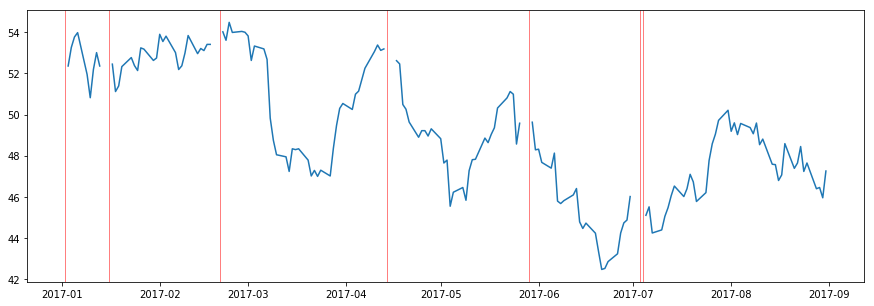

In [4]:
oil_ts = pd.Series(oil.dcoilwtico.values, index=oil.date)
oil_ts2 = oil_ts['2017']

plt.figure(figsize=(15,5))
plt.plot(oil_ts2)

for date in oil[(oil.dcoilwtico.isnull()) & (oil.date>="2017-01-01")]['date']:
    plt.axvspan(date, date, color='red', alpha=0.5)

plt.show()

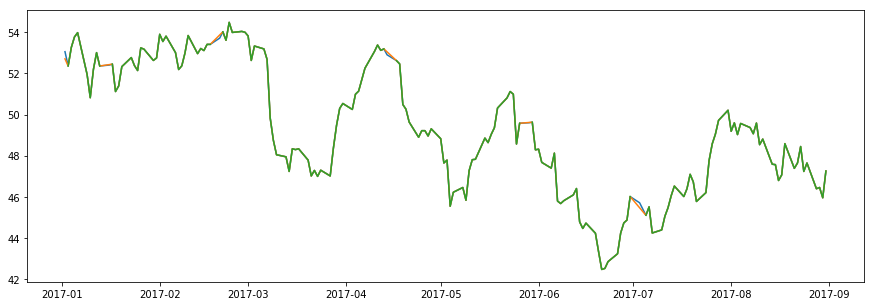

In [5]:
ts1 = oil_ts.interpolate()
ts2 = oil_ts.interpolate(method='time')
ts3 = oil_ts.interpolate(method='spline', order=4)

plt.figure(figsize=(15,5))
plt.plot(ts1['2017'])
plt.plot(ts2['2017'])
plt.plot(oil_ts['2017'])
plt.show()

In [6]:
miss_dates = oil[oil.dcoilwtico.isnull()]['date']
miss_dates

pd.DataFrame({'linear':ts1[miss_dates], 
              'time':ts2[miss_dates],
              'spline':ts3[miss_dates]}).head(10)

,linear,spline,time
date,,,
2013-01-01,NaN,NaN,NaN
2013-01-21,95.850,95.287115,95.9700
2013-02-18,96.320,95.074146,96.5050
2013-03-29,97.170,95.882429,97.2050
2013-05-27,94.245,93.643313,94.4475
2013-07-04,102.505,101.197697,102.5050
2013-09-02,108.325,109.242172,108.4975
2013-11-28,92.300,94.324847,92.3000
2013-12-25,99.025,99.116694,99.0250


In [7]:
oil = ts1.to_frame('dcoilwtico')
oil.reset_index(inplace=True)
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
sales=pd.merge(sales,oil,how='left')
sales.head()

,date,store_nbr,transactions,city,state,type,cluster,dcoilwtico
0,2013-01-01,25,770,Salinas,Santa Elena,D,1,NaN
1,2013-01-02,1,2111,Quito,Pichincha,D,13,93.14
2,2013-01-02,2,2358,Quito,Pichincha,D,13,93.14
3,2013-01-02,3,3487,Quito,Pichincha,D,8,93.14
4,2013-01-02,4,1922,Quito,Pichincha,D,9,93.14


# Feature engineering

### Date

First, let's work on creating features derived from the date, which is expected to be an important field as we are working with time series

In [9]:
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day
sales['week'] = sales['date'].dt.week
sales['dow'] = sales['date'].dt.dayofweek
sales['dayofyear'] = sales['date'].dt.dayofyear
sales['dayoff']=[x in [5,6] for x in sales.dow] ## Weekends

#sales[sales.dow==6].head()

### Holiday events
This events are expected to be correlated with high volume sales

In [10]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
# Enable all holidays
for (d,t,l,n) in zip(holidays.date,holidays.type,holidays.locale,holidays.locale_name):
    if t!='Work Day' and t!='Event':  
        if l=='National':
            sales.loc[sales.date==d,'dayoff']=True
        elif l=='Regional':
            sales.loc[(sales.date==d)&(sales.state==n),'dayoff']=True
        else:
            sales.loc[(sales.date==d)&(sales.city==n),'dayoff']=True
    else:
        sales.loc[(sales.date==d),'dayoff']=False


In [12]:
## Some manual verifications
sales.loc[lambda df: df.date=='2015-01-10'].head()
#sales.loc[lambda df: (df.date=='2017-04-13') & (df.city=='Cuenca')].head()
#sales.loc[lambda df: (df.date=='2013-04-01') & (df.state=='Cotopaxi')].head()

,date,store_nbr,transactions,city,state,type,cluster,dcoilwtico,year,month,day,week,dow,dayofyear,dayoff
34431,2015-01-10,1,1534,Quito,Pichincha,D,13,NaN,2015,1,10,2,5,10,False
34432,2015-01-10,2,2083,Quito,Pichincha,D,13,NaN,2015,1,10,2,5,10,False
34433,2015-01-10,3,3601,Quito,Pichincha,D,8,NaN,2015,1,10,2,5,10,False
34434,2015-01-10,4,1689,Quito,Pichincha,D,9,NaN,2015,1,10,2,5,10,False
34435,2015-01-10,5,1645,Santo Domingo,Santo Domingo de los Tsachilas,D,4,NaN,2015,1,10,2,5,10,False


### Transactions


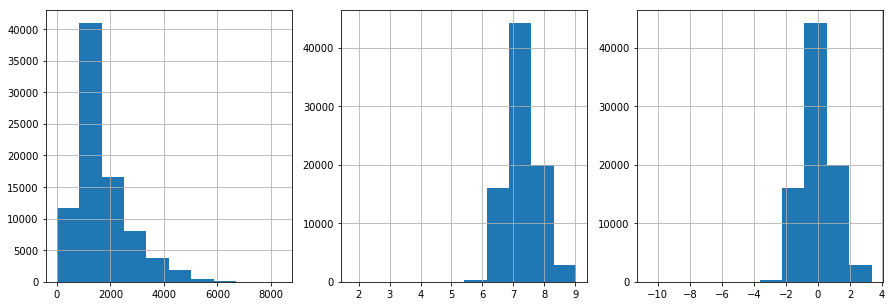

In [13]:
# Transformation
sales['transactions2'] = np.log1p(sales.transactions)

# Normalized
sales['transactions3'] = (sales['transactions2'] - sales['transactions2'].mean()) / sales['transactions2'].std()

# Histograms
plt.figure(figsize=(15,5))
sales.transactions.hist(ax=plt.subplot(1,3,1))
sales.transactions2.hist(ax=plt.subplot(1,3,2))
sales.transactions3.hist(ax=plt.subplot(1,3,3))

In [14]:
# Denormalize
def denormalize_target(sales, target, transform=False):
    target_std = sales['transactions2'].std()
    target_mean = sales['transactions2'].mean()

    out = target * target_std + target_mean
    if transform:
        out = np.expm1(out)
    
    return out
    
#test = denormalize_target(sales, sales.transactions3, True)
#test.hist()

Both distributions are skewed. But the transformed looks more normal

### Categorical features

Use one-hot encoding for city, state, type.
This might create hundreds of features, which could be restricting given the amount of data.

In [15]:
cat_columns = ['store_nbr','city', 'state', 'type']

def encode(df, column) -> pd.DataFrame:
    one_hot = pd.get_dummies(df[column], drop_first=False, prefix=column)
    return (one_hot - one_hot.mean()) / one_hot.std()

for column in cat_columns:
    column_enc = encode(sales, column)
    sales = pd.concat([sales,column_enc], axis=1)

#sales.drop([c for c in cat_columns if c!='store_nbr'], axis=1, inplace=True)

In [16]:
#sales.info()
[c for c in sales.columns]

['date',
 'store_nbr',
 'transactions',
 'city',
 'state',
 'type',
 'cluster',
 'dcoilwtico',
 'year',
 'month',
 'day',
 'week',
 'dow',
 'dayofyear',
 'dayoff',
 'transactions2',
 'transactions3',
 'store_nbr_1',
 'store_nbr_2',
 'store_nbr_3',
 'store_nbr_4',
 'store_nbr_5',
 'store_nbr_6',
 'store_nbr_7',
 'store_nbr_8',
 'store_nbr_9',
 'store_nbr_10',
 'store_nbr_11',
 'store_nbr_12',
 'store_nbr_13',
 'store_nbr_14',
 'store_nbr_15',
 'store_nbr_16',
 'store_nbr_17',
 'store_nbr_18',
 'store_nbr_19',
 'store_nbr_20',
 'store_nbr_21',
 'store_nbr_22',
 'store_nbr_23',
 'store_nbr_24',
 'store_nbr_25',
 'store_nbr_26',
 'store_nbr_27',
 'store_nbr_28',
 'store_nbr_29',
 'store_nbr_30',
 'store_nbr_31',
 'store_nbr_32',
 'store_nbr_33',
 'store_nbr_34',
 'store_nbr_35',
 'store_nbr_36',
 'store_nbr_37',
 'store_nbr_38',
 'store_nbr_39',
 'store_nbr_40',
 'store_nbr_41',
 'store_nbr_42',
 'store_nbr_43',
 'store_nbr_44',
 'store_nbr_45',
 'store_nbr_46',
 'store_nbr_47',
 'store_nb

In [17]:
#sel_cols = [c for c in sales.columns if c.startswith('store_nbr_')]
#sel_cols = [c for c in sales.columns if c.startswith('city_')]
#sel_cols = [c for c in sales.columns if c.startswith('state_')]
#sales[sel_cols].head()

In [18]:
some_cols = [c for c in sales.columns if 
             not c.startswith('store_nbr_') and 
             not c.startswith('city_') and 
             not c.startswith('state') and 
             not c.startswith('type_')]

### Lagged features: lag_7 (weekly trend)

In [19]:
## Fill missing rows using a product between the stores and the dates (range min-max)

#u_dates = sales.date.unique() # There are no records for some dates (eg: 25-dic)
dates_range =  pd.date_range(sales.date.min(), sales.date.max())
u_stores = sales.store_nbr.unique()

sales2 = sales.copy()
sales2.set_index(["date", "store_nbr"], inplace=True)
sales2 = sales2.reindex(
    pd.MultiIndex.from_product(
        [dates_range, u_stores],
        names=["date", "store_nbr"]
    )
)
sales2 = sales2.sort_index()
some_cols2 = [c for c in some_cols if c!='date' and c!='store_nbr']

In [20]:
sales2['lag_7']=np.nan
sales2['lag_7']=sales2['transactions2'].shift(7*len(u_stores))
sales2[['transactions2','lag_7']].corr()

,transactions2,lag_7
transactions2,1.000000,0.959216
lag_7,0.959216,1.000000


### Lagged features: lag_365 (anual trend)

In [21]:
sales2['lag_annual']=np.nan
sales2['lag_annual']=sales2['transactions2'].shift(364*len(u_stores))
sales2[['transactions2','lag_annual']].corr()

,transactions2,lag_annual
transactions2,1.000000,0.961503
lag_annual,0.961503,1.000000


In [22]:
sales2['lag_annual']=np.nan

## Selecting MultiIndex dataframe
dateindex = sales2.index.get_level_values('date')
storeindex = sales2.index.get_level_values('store_nbr')
#sales2.loc[dateindex.year == 2014]
#sales2.loc[dateindex == '2017-05-09']
#sales2.loc[(dateindex == '2017-05-09') & (storeindex==1)]
#sales2.loc[(dateindex.year == 2014) & (storeindex==25)]

for year in reversed(range(2014,2018)):
    hop = 365
    if year==2017: 
        hop = 366

    sales2.loc[dateindex.year.isin([year,year-1]),'lag_annual'] = \
    sales2.loc[dateindex.year.isin([year,year-1]),'transactions2'].shift(hop*len(u_stores))

sales2[['transactions2','lag_annual']].corr()

# Check
# sales2.loc[(dateindex.month==2) & (dateindex.day==2) & (storeindex==25),['transactions2','lag_annual']]

,transactions2,lag_annual
transactions2,1.000000,0.910141
lag_annual,0.910141,1.000000


In [23]:
# Delete temporal df
sales = sales2.reset_index()
del sales2

# EDA

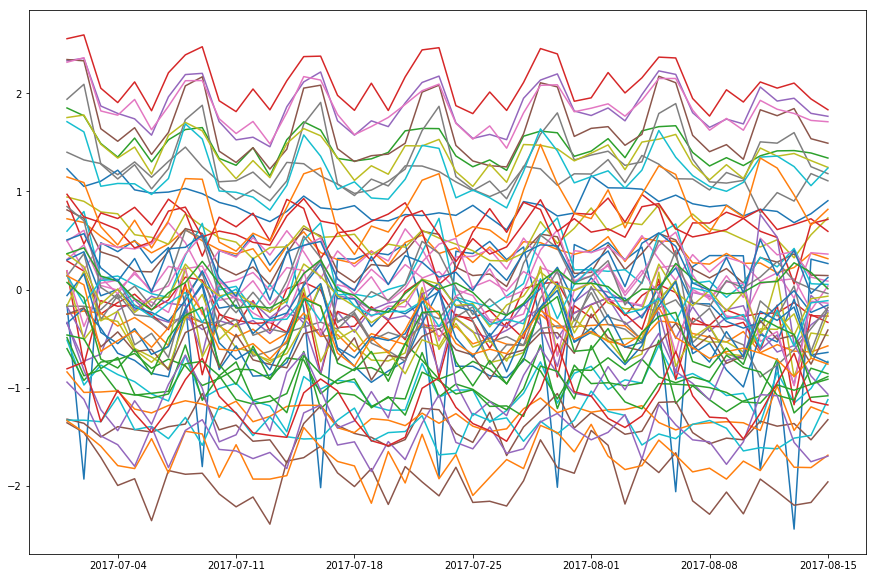

In [24]:
plt.figure(figsize=(15,10))

for store in sorted(sales.store_nbr.unique()):
    a_store = sales[(sales.store_nbr==store) & (sales.date>='2017-07-01')]
    ts = pd.Series(a_store['transactions3'].values, index = a_store.date)
    plt.plot(ts, label='Store %s'%(store))
    
plt.show()

# Prediction

### Drop nan

In [25]:
sales.dropna(inplace=True)
print(sales.shape)

(45373, 116)


### Sorting data

In [26]:
sales.sort_values(['store_nbr', 'date'], ascending=[True, True], inplace=True)
sales.index=range(sales.shape[0])
sales = sales.reindex()
#sales.head()

### Splitting data

In [27]:
#sales['prediction'] = None

X1 = sales.loc[(sales.date<'2017-08-01') & (sales.date>='2016-01-01')]
X2  = sales.loc[sales.date>='2017-08-01'].copy()

target_column = 'transactions2' 
y1 = X1[target_column].values
y2 = X2[target_column].values

### MLP

In [28]:
from sklearn import metrics

np.random.seed(1122)

cols = [c for c in X1 if c not in ['date','store_nbr','type','city','state',
                                   'transactions','transactions2','transactions3',
                                   'prediction']]

number_regressors_to_test = 3
for method in range(1, number_regressors_to_test+1):
    print('\nmethod = ', method)
    
    if (method==1):
        print('Multilayer perceptron (MLP) neural network 01')
        str_method = 'MLP model01'    
        r = MLPRegressor(hidden_layer_sizes=(3,), max_iter=100)
    if (method==2):
        print('Bagging Regressor 01')
        str_method = 'BaggingRegressor01'
        r = BaggingRegressor(DecisionTreeRegressor(max_depth=6,max_features=0.85))        

    if (method==3):
        np.random.seed(1122)
        print('GradientBoosting 01')
        str_method = 'GradientBoosting01'
        r = GradientBoostingRegressor(n_estimators=85, max_depth=6, learning_rate = 0.01, 
                                       verbose=0, warm_start=True,
                                       subsample= 0.87, max_features = 0.8)        

    r.fit(X1[cols], y1)
    yh2 = r.predict(X2[cols])
    X2['prediction_%d'%method] = yh2
    m = metrics.mean_squared_error(y2, yh2)**0.5

    print("Error: %f" % (m))


method =  1
Multilayer perceptron (MLP) neural network 01
Error: 0.110811

method =  2
Bagging Regressor 01
Error: 0.105016

method =  3
GradientBoosting 01
Error: 0.232989


In [29]:
X2.head()

,date,store_nbr,transactions,city,state,type,cluster,dcoilwtico,year,month,...,type_A,type_B,type_C,type_D,type_E,lag_7,lag_annual,prediction_1,prediction_2,prediction_3
921,2017-08-01,1,1795.0,Quito,Pichincha,D,13.0,49.19,2017.0,8.0,...,-0.43985,-0.401878,-0.635502,1.387063,-0.272575,7.487734,6.129050,7.467328,7.376821,7.320058
922,2017-08-02,1,1892.0,Quito,Pichincha,D,13.0,49.60,2017.0,8.0,...,-0.43985,-0.401878,-0.635502,1.387063,-0.272575,7.551712,7.467942,7.479102,7.501264,7.392376
923,2017-08-03,1,1726.0,Quito,Pichincha,D,13.0,49.03,2017.0,8.0,...,-0.43985,-0.401878,-0.635502,1.387063,-0.272575,7.455877,7.441907,7.477991,7.449887,7.371196
924,2017-08-04,1,1847.0,Quito,Pichincha,D,13.0,49.57,2017.0,8.0,...,-0.43985,-0.401878,-0.635502,1.387063,-0.272575,7.522400,7.519692,7.479257,7.494560,7.383606
925,2017-08-07,1,1665.0,Quito,Pichincha,D,13.0,49.37,2017.0,8.0,...,-0.43985,-0.401878,-0.635502,1.387063,-0.272575,7.535297,7.128496,7.465978,7.370415,7.320631


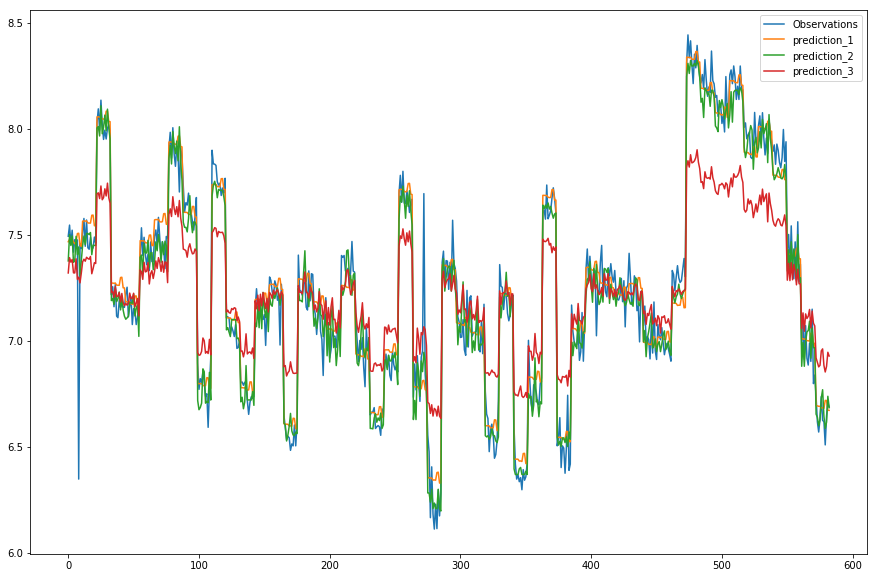

In [30]:
ts  = pd.Series(X2[target_column].values)

plt.figure(figsize=(15,10))
plt.plot(ts, label='Observations')

for c in [c for c in X2.columns if c.startswith("prediction_")]:
    ts_p = pd.Series(X2[c].values)
    plt.plot(ts_p,label=c)

plt.legend()

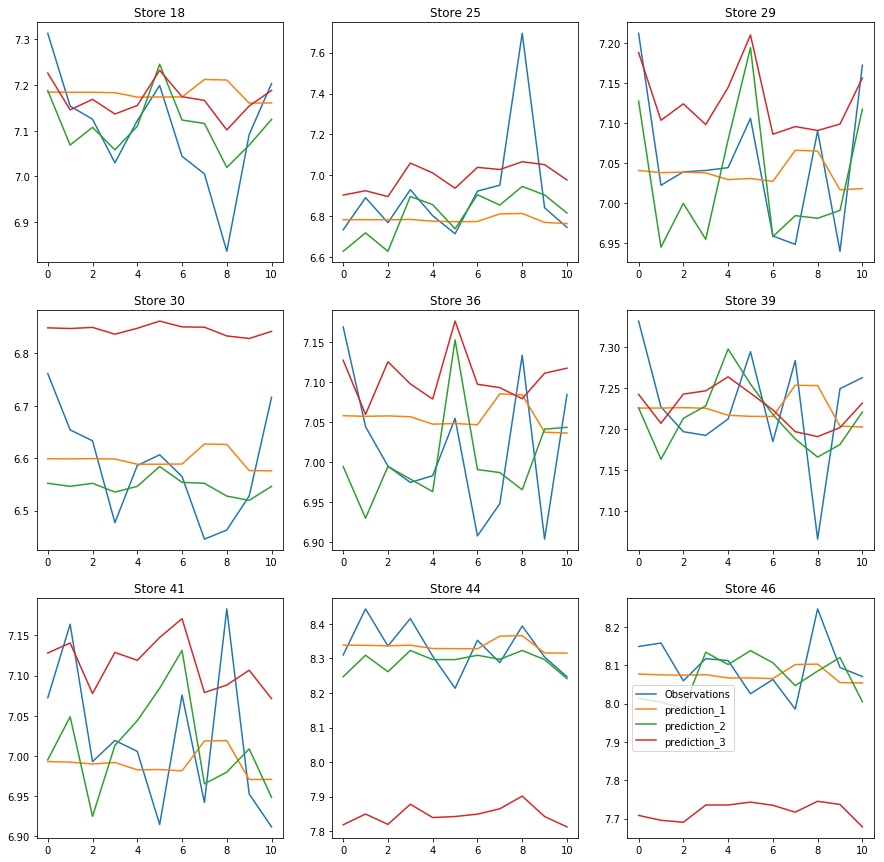

In [31]:
import random
random_stores =  sorted(u_stores[random.sample(range(len(u_stores)), 9) ])

plt.figure(figsize=(15,15))

for i in range(len(random_stores)):
    ax1 = plt.subplot(3,3,i+1)
    a_store = X2[X2.store_nbr==random_stores[i]]
    ts = pd.Series(a_store[target_column].values) # , index = a_store.date
    ax1.plot(ts, label='Observations')
    
    for c in [c for c in X2.columns if c.startswith("prediction_")]:
        ts_p = pd.Series(a_store[c].values) # , index = a_store.date
        ax1.plot(ts_p,label=c)

    plt.title('Store {}'.format(random_stores[i]))

plt.legend()

# Conclusions

Some experiments regarding categorical feature encoding showed that:
- One-hot encoding works better than preprocessing.LabelEncoder()

The sequentially resulting RMSEs for the method 1 (MLP) were:
- Label encoding: 0.517800
- One-hot encoding: 0.247412
- Lag-7 & Lag-annual: 0.135791
- Oil price: 0.110811

Among the regressors tested, Bagging Regressor 01 (RMSE 0.105016) seems to be the best

# Build dataset

In [33]:
#[c for c in sales.columns]
sales.to_csv('../input/processed/sales+.csv', index=False)